<a href="https://colab.research.google.com/github/gqkd/MRI_Brain_Tumor_Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download dataset and installations**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

#first download the dataset from this link, you need to be logged in
# https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/download?datasetVersionNumber=1
# save it in your google drive, for this notebook this is the path /content/drive/MyDrive/Datasets/Brain_MRI_Images_for_Brain_tumor_detection/archive.zip
# make a new directory
!mkdir dataset
%cd dataset
!cp /content/drive/MyDrive/Datasets/Brain_MRI_Images_for_Brain_tumor_detection/archive.zip .
!unzip -q archive.zip
!pip install diptest

/content/dataset
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 2.9 MB/s eta 0:00:00


#**Import**

In [31]:
import pandas as pd
import os
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import entropy, skew
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#**Functions**

In [32]:
def load_data(parent_folder_path: str) -> np.array:
  path_parent = parent_folder_path + '/**'
  X=[]
  y=[]
  for path in glob.glob(path_parent, recursive=True):
    if os.path.isfile(path):
      img = cv2.imread(path)
      X.append(img)
      if os.path.basename(os.path.dirname(path)) == "yes":
        y.append(1)
      else:
        y.append(0)
  return np.array(X), np.array(y)

def plot_classes_distribution(y :np.array, name: str = '' ) -> None:
  plt.figure(figsize=(10,5))

  # Check if y is not a list (single array)
  if not isinstance(y,list):
    classes, counts = np.unique(y, return_counts=True)

    plt.bar(classes,counts,width=0.5,color=['green','red'])
    plt.xticks(classes, ['No','Yes'])
    plt.title(f'Classes distribution {name}')
  else:

    y_max=0 # Variable to store the maximum y-axis value across all subplots

    plt.suptitle('Classes distribution')
    for i,el in enumerate(y):
      classes, counts = np.unique(el, return_counts=True)
      plt.subplot(1,3,i+1)
      plt.bar(classes,counts,width=0.5,color=['green','red'])
      plt.xticks(classes, ['No','Yes'])
      plt.title(f'{name[i]}')

      y_max = max(y_max, max(counts)) # Update the maximum y value

      # Set a common y-axis range for all subplots
      for ax in plt.gcf().get_axes():
        ax.set_ylim(0, y_max+10) # Add some extra margin to the maximum y value

  plt.tight_layout()

#same function of imutils

def grab_contours(cnts:tuple) -> tuple:
  # if the length the contours tuple returned by cv2.findContours
  # is '2' then we are using either OpenCV v2.4, v4-beta, or
  # v4-official
  if len(cnts) == 2:
      cnts = cnts[0]

  # if the length of the contours tuple is '3' then we are using
  # either OpenCV v3, v4-pre, or v4-alpha
  elif len(cnts) == 3:
      cnts = cnts[1]

  # otherwise OpenCV has changed their cv2.findContours return
  # signature yet again and I have no idea WTH is going on
  else:
      raise Exception(("Contours tuple must have length 2 or 3, "
          "otherwise OpenCV changed their cv2.findContours return "
          "signature yet again. Refer to OpenCV's documentation "
          "in that case"))

  # return the actual contours array
  return cnts

def crop (set_to_crop: np.array, pixel_to_add: int=0, tresh_method: str = 'static') -> np.array:
  #different modality for tresholding:
  # - static, normal tresholding with a fixed tresh
  # - adaptive_mean, The threshold value is the mean of the neighbourhood area minus the constant C
  # - adaptive_gaussian, The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant C.
  # - otsu, apply to otsu binarization technique
  # preprocessing, pretty much like this cropping https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
  IMG_SIZE = (224,224)
  new_set = []

  for img_rgb in set_to_crop:
    img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 0)
    if tresh_method == 'static':
      thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY)[1]
    #TODO test this
    # elif tresh_method == 'adaptive_mean':
    #   thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    # elif tresh_method == 'adaptive_gaussian':
    #   thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN, cv2.THRESH_BINARY, 11, 2)
    elif tresh_method == 'otsu':
      thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(max_contour[max_contour[:, :, 0].argmin()][0])
    extRight = tuple(max_contour[max_contour[:, :, 0].argmax()][0])
    extTop = tuple(max_contour[max_contour[:, :, 1].argmin()][0])
    extBot = tuple(max_contour[max_contour[:, :, 1].argmax()][0])

    new_img = img[extTop[1]-pixel_to_add:extBot[1]+pixel_to_add, extLeft[0]-pixel_to_add:extRight[0]+pixel_to_add].copy()
    #TODO, adding pixels can produce error when the border is the border of the image
    # control to not exceed image boundaries

    #interpolation INTER_CUBIC is good for enlarge and INTER_NEAREST for shrink
    if np.shape(img)[0] > IMG_SIZE[0] or np.shape(img)[1] > IMG_SIZE[0]:
      # the image is bigger than IMG_SIZE
      new_img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    else: #the image is smaller than IMG_SIZE
      new_img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)

    new_set.append(new_img)

  return np.array(new_set)


def ratio_imgs(set_name: np.array) -> None:

  #size of the images
  list_sizes = []
  list_ratios = []
  for img in set_name:
    list_sizes.append(img.shape)
    list_ratios.append(img.shape[0]/img.shape[1])

  # plt.hist(list_sizes)
  plt.figure()
  _ = plt.hist(list_ratios, bins=20)
  plt.title('Distribution of ratios')


def plot_samples(set_name: np.array, set_labels: np.array,  num_samples: int = 50) -> None:

  columns = 10
  plt.figure(figsize=(10,5))
  for i in range(num_samples):
    rnd = random.randint(0,len(set_name))

    plt.subplot(int(num_samples/columns),columns,i+1)
    plt.imshow(set_name[rnd-1], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('yes' if set_labels[rnd]==1 else 'no')
    plt.tight_layout()

    #TODO gives an error when it select the last imageù

def save_images(X, y, folder_name):
    i = 0
    for (img, imclass) in zip(X, y):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

#**Loading dataset**

In [6]:
path = "/content/dataset/brain_tumor_dataset"
X, y = load_data(path)

<ipython-input-5-f3e9aca46eda>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


#**EDA**

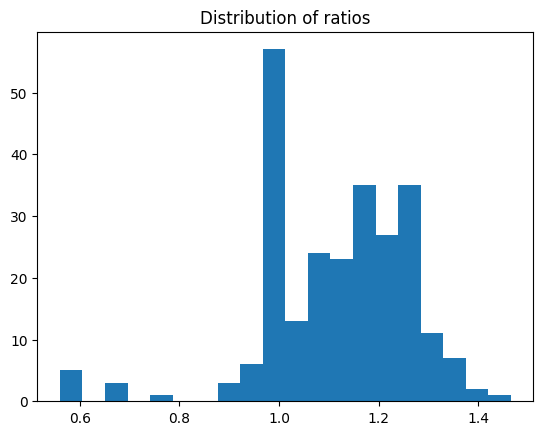

In [7]:
# Distribution of ratios
ratio_imgs(X)

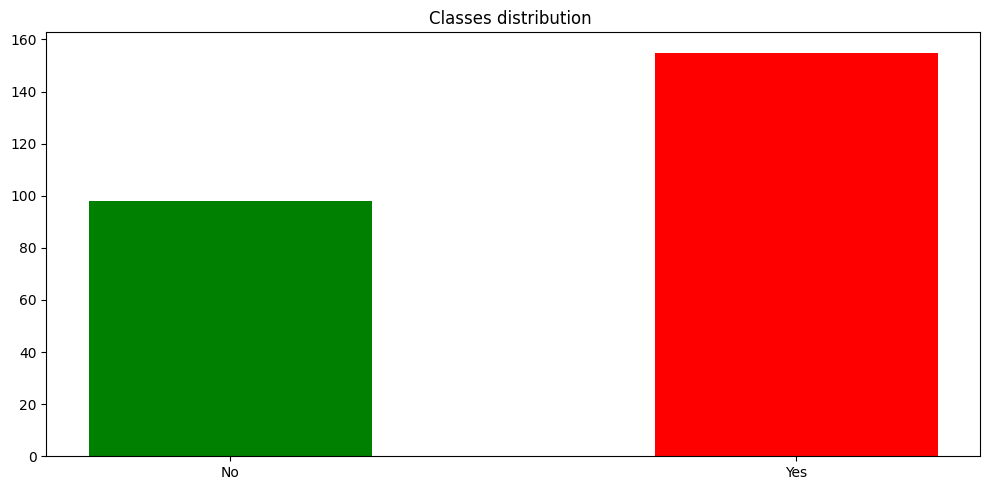

In [8]:
#distribution of classes initial dataset
plot_classes_distribution(y,name='')

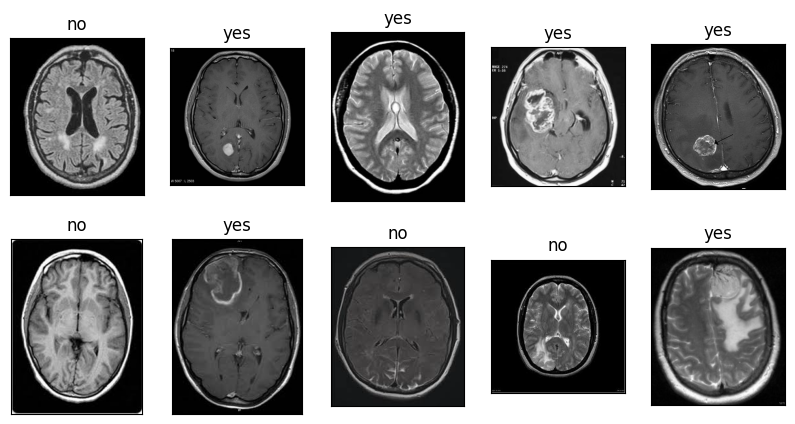

In [9]:
#plot examples from original dataset

plt.figure(figsize=(10,5))
for i in range(10):
  rnd = random.randint(0,len(X))
  plt.subplot(2,5,i+1)
  plt.imshow(X[rnd])
  plt.xticks([])
  plt.yticks([])
  plt.title('yes' if y[rnd]==1 else 'no')
  # plt.tight_layout()

In [10]:
# splitting
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_remain, y_remain, test_size=0.5, random_state=42)

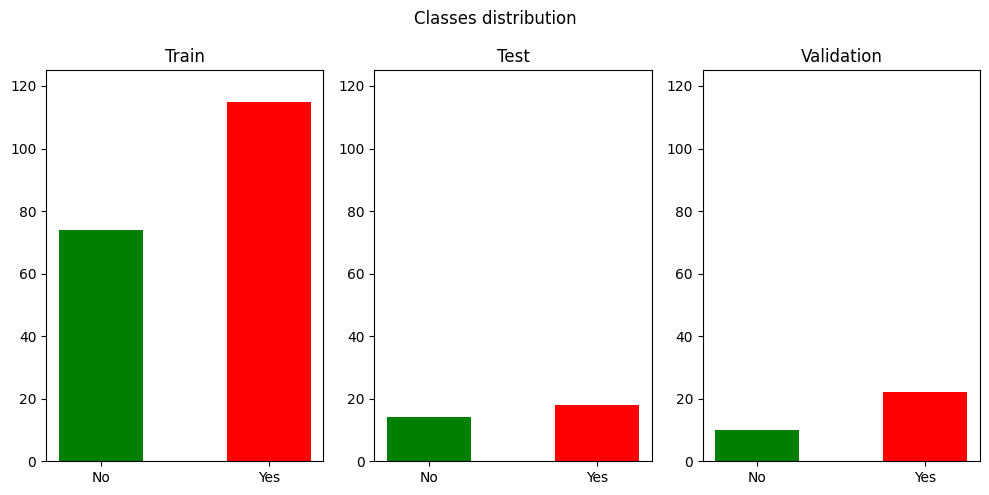

In [11]:
#distribution of classes train test and validation
plot_classes_distribution([y_train,y_test,y_val],['Train','Test','Validation'])

#**Interpolation**

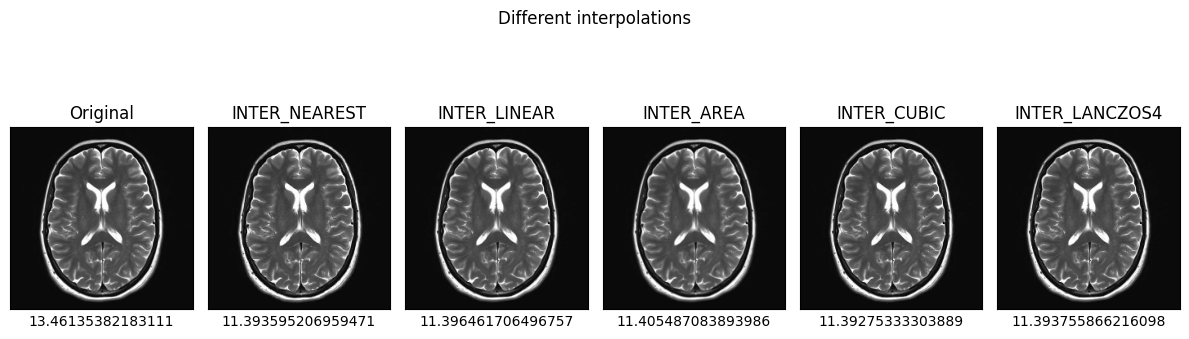

In [12]:

IMG_SIZE = (224,224)
img = X[0]

#different interpolations
dict_interpolations = {
  'INTER_NEAREST': cv2.INTER_NEAREST,  # fastest, blockiest
  'INTER_LINEAR': cv2.INTER_LINEAR,   # good compromise
  'INTER_AREA': cv2.INTER_AREA,    # slower, smoother than INTER_LINEAR
  'INTER_CUBIC': cv2.INTER_CUBIC,   # slowest, smoothest
  'INTER_LANCZOS4': cv2.INTER_LANCZOS4,  # even slower, even smoother
}

plt.figure(figsize=(12,4))
plt.suptitle('Different interpolations')
plt.subplot(1,6,1)
plt.imshow(img)
plt.title('Original')
plt.xticks([])
plt.yticks([])
plt.xlabel(f'{entropy(img.ravel())}')

for i,interp in enumerate(dict_interpolations):
  plt.subplot(1,6,i+2)
  imginterp = cv2.resize(img, dsize=IMG_SIZE, interpolation=dict_interpolations[interp])
  plt.imshow(imginterp)
  plt.title( str(interp))
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'{entropy(imginterp.ravel())}')
plt.tight_layout()

# INTER_NEAREST: fastest, blockiest, good for shrinking
# INTER_LINEAR: good compromise, good for both shrinking and enlarging
# INTER_AREA: slower, smoother than INTER_LINEAR, good for shrinking
# INTER_CUBIC: slowest, smoothest, good for enlarging
# INTER_LANCZOS4: even slower, even smoother, good for enlarging

# For resizing an image to 224x224 pixels, INTER_LINEAR or INTER_CUBIC are good choices.
# INTER_NEAREST is a good choice for shrinking images, while INTER_CUBIC is a good choice for enlarging images.

# INTER_CUBIC is ok

#TODO control if it is possible to cut the black before interpolation, maybe there is less loss of information

#**Statistical test**

dip =  (0.011583212523103584, 0.5262722313078084)
dip =  (0.07727810522735253, 0.0)
mean of dip test = 0.07148333196238571
mean of dip test p-value = 0.0


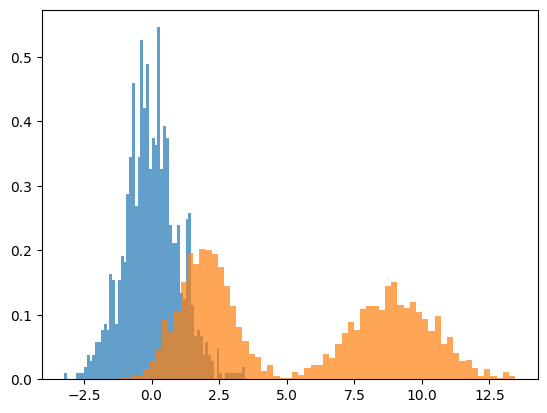

In [13]:
import diptest
#histograms
# to check if the otsu threshold technique can be applied
# the histograms must have a bimodal distribution

#example for dip test

# a normal distribution must have a very low skewness
data = np.random.normal(0,1,1000)
plt.hist(data, 64, density=True, alpha=0.7)

#the skew is near zero
print('dip = ', diptest.diptest(data))

#lets see a bimodal distribution
# Parameters for the two normal distributions
mean1 = 2.0
std_dev1 = 1.0
size1 = 1000

mean2 = 9.0
std_dev2 = 1.5
size2 = 1000

# Generate random samples from the two normal distributions
data1 = np.random.normal(mean1, std_dev1, size1)
data2 = np.random.normal(mean2, std_dev2, size2)

# Combine the two datasets to create a bimodal distribution
bimodal_data = np.concatenate((data1, data2))

plt.hist(bimodal_data, 64, density=True, alpha=0.7)

print('dip = ', diptest.diptest(bimodal_data))

# the dip test does not check for bimodality, only look if is not unimodal

dip_vector = []
dip_pvalue = []
for i in range(len(X)):
  img = X[i]
  dip_vector.append(diptest.diptest(img.ravel())[0])
  dip_pvalue.append(diptest.diptest(img.ravel())[1])
print('mean of dip test =', np.mean(dip_vector))
print('mean of dip test p-value =', np.mean(dip_pvalue))

#TODO other tests, or other packages, because is strange that the p-value is always zero
# from here https://stats.stackexchange.com/questions/156808/interpretation-of-hartigans-dip-test
# the p-value for a bimodal distribution must be between 0.05 and 0.10

# other tests mode hunting, jarque-bera, lilliefors, Silverman test, kde visual inspection

#**Preprocessing demo**

image num.  213
original entropy 11.177272755485824
entropy after conversion 10.078660466817713
Contour 1: 6 points
Contour 2: 361 points
Contour 3: 170 points
Contour 4: 48 points


([], [])

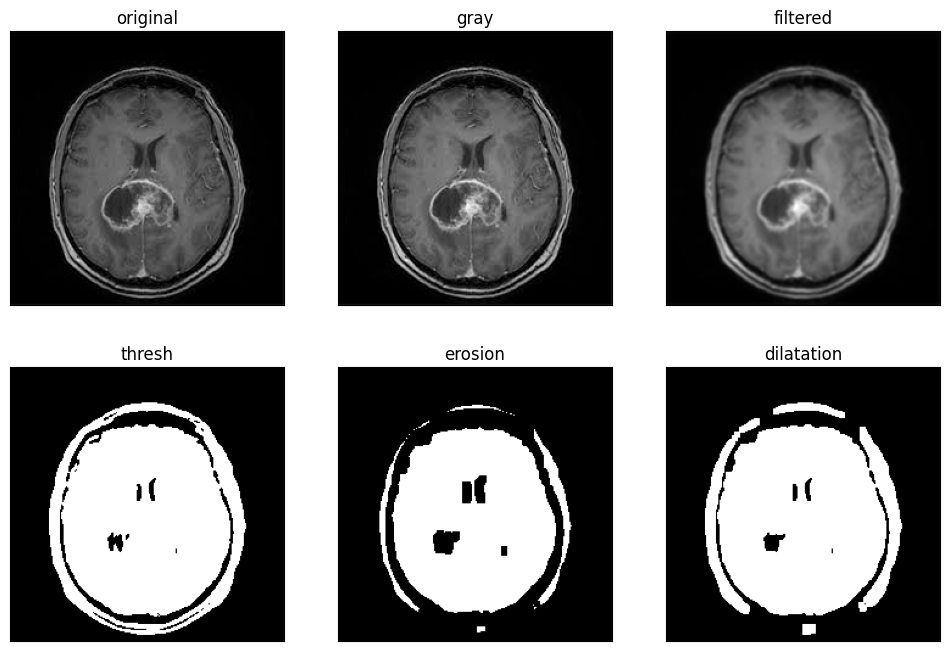

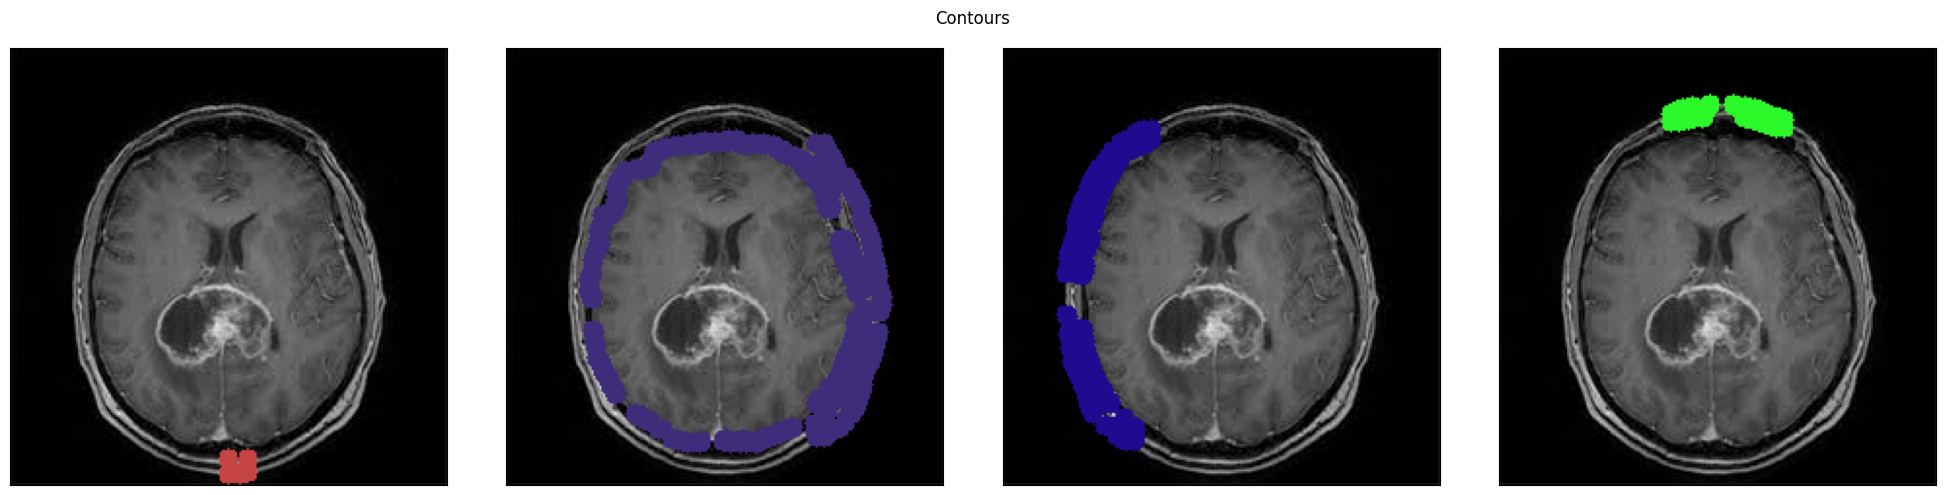

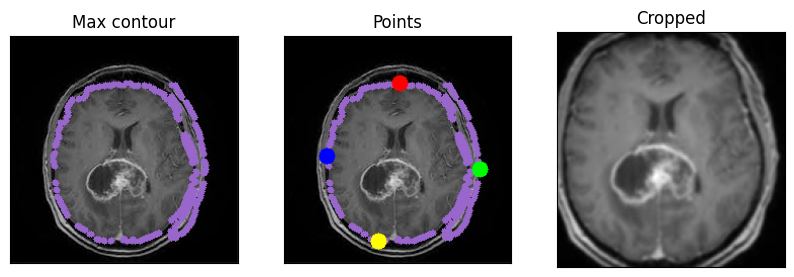

In [14]:
# preprocessing, one image, cropping https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
IMG_SIZE = (224,224)
rnd = random.randint(1, len(X))
print('image num. ', rnd )
img_rgb = X[rnd]

# from RGB to gray scale

#before converting it we have to check if we are losing information with the gray scale conversion
# a simple way is to calculate the entropy after and before
print(f'original entropy {entropy(img_rgb.ravel())}')
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(img_rgb)
plt.title('original')
plt.xticks([])
plt.yticks([])

img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.subplot(2,3,2)
plt.imshow(img,cmap='gray')
plt.title('gray')
plt.xticks([])
plt.yticks([])
print(f'entropy after conversion {entropy(img.ravel())}')

#TODO too much information is lost with the conversion

# gaussian filter
img = cv2.GaussianBlur(img, (5,5), 0)
plt.subplot(2,3,3)
plt.imshow(img,cmap='gray')
plt.title('filtered')
plt.xticks([])
plt.yticks([])

thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY)[1]

#TODO code to try https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
# for otsu tresh
# thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# for adaptive tresh
# thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
# thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN, cv2.THRESH_BINARY, 11, 2)
plt.subplot(2,3,4)
plt.imshow(thresh,cmap='gray')
plt.title('thresh')
plt.xticks([])
plt.yticks([])

thresh = cv2.erode(thresh, None, iterations=2)
plt.subplot(2,3,5)
plt.imshow(thresh,cmap='gray')
plt.title('erosion')
plt.xticks([])
plt.yticks([])

thresh = cv2.dilate(thresh, None, iterations=2)
plt.subplot(2,3,6)
plt.imshow(thresh,cmap='gray')
plt.title('dilatation')
plt.xticks([])
plt.yticks([])

# find contours in thresholded image, then grab the largest
# one
cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# first one is the retrieval mode,
# RETR_EXTERNAL retrieves only the extreme outer contours
# RETR_LIST retrieves all of the contours and organizes them into a two-level hierarchy. At the top level, there are external boundaries of the components.
#           At the second level, there are boundaries of the holes. If there is another contour inside a hole of a connected component, it is still put at the top level.
# RETR_TREE  retrieves all of the contours and reconstructs a full hierarchy of nested contours.
# RETR_FLOODFILL  not specified in the documentation

# second one is the aproximation method
# CHAIN_APPROX_NONE stores absolutely all the contour points.
# CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points.
#                     For example, an up-right rectangular contour is encoded with 4 points.
# CHAIN_APPROX_TC89_L1, CHAIN_APPROX_TC89_KCOS, Teh-Chin chain approximation algorithm


# cnts = imutils.grab_contours(cnts) #basically this is doing cnts[0] when you don't specify hierarchy in the output of findContours
# cnts = cnts[0] #this is the same for openCV version 2.4

# Contours tuple must have length 2 or 3, otherwise OpenCV changed their cv2.findContours return
for i in range(len(cnts)):
    n_points = len(cnts[i])
    print(f"Contour {i + 1}: {n_points} points")


num_contours = len(cnts)
plt.figure(figsize=(20, 5))
plt.suptitle("Contours")
for i in range(len(cnts)):
    img_ = img_rgb.copy()
    plt.subplot(1,num_contours,i+1)
    color = np.random.randint(0, 256, 3) #random select a color
    color = (int(color[0]), int(color[1]), int(color[2])) #conversion from int64 to int because opencv does not like int64
    cv2.drawContours(img_, cnts[i], -1, tuple(color), 10)
    plt.imshow(img_,cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


max_contour = max(cnts, key=cv2.contourArea)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("Max contour")
img_ = img_rgb.copy()
cv2.drawContours(img_, max_contour, -1, (153, 102, 204), 5)
plt.imshow(img_,cmap='gray')
plt.xticks([])
plt.yticks([])

# find the extreme points
extLeft = tuple(max_contour[max_contour[:, :, 0].argmin()][0])
extRight = tuple(max_contour[max_contour[:, :, 0].argmax()][0])
extTop = tuple(max_contour[max_contour[:, :, 1].argmin()][0])
extBot = tuple(max_contour[max_contour[:, :, 1].argmax()][0])

# add extreme points
img_pnt = cv2.circle(img_.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

plt.subplot(1,3,2)
plt.imshow(img_pnt,cmap='gray')
plt.title("Points")
plt.xticks([])
plt.yticks([])

# crop
ADD_PIXELS = 5
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

plt.subplot(1,3,3)
plt.imshow(new_img,cmap='gray')
plt.title("Cropped")
plt.xticks([])
plt.yticks([])

#TODO some images have some writings in the upper left and in the lower left
# implement in the preprocessing ocr to recognize writings and delete it
# is important to avoid the CNN to learn the writings and make decision based on that

#**Preprocessing**

In [15]:
X_train_crop = crop (X_train)
X_val_crop = crop (X_val)
X_test_crop = crop (X_test)

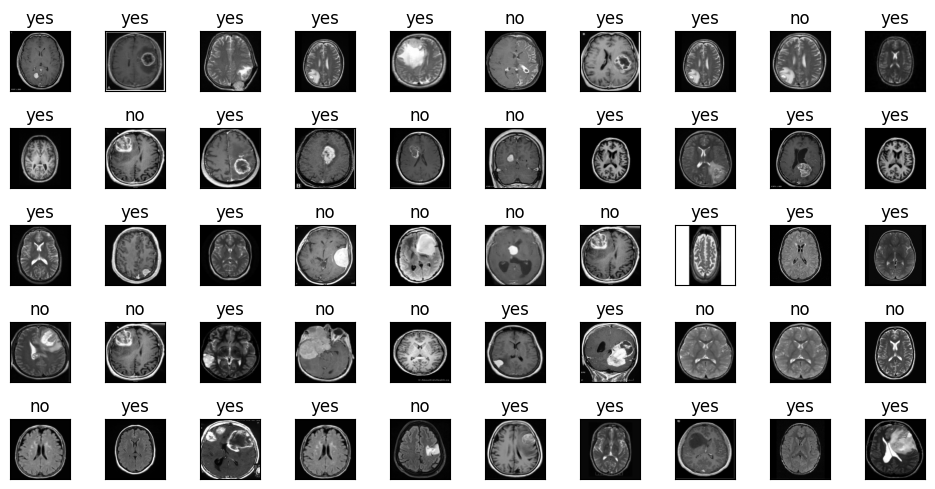

In [16]:
#plot examples from cropped dataset
plot_samples(X_train_crop, y_train)

In [18]:
!mkdir CROP CROP/TRAIN_CROP CROP/TEST_CROP CROP/VAL_CROP CROP/TRAIN_CROP/YES CROP/TRAIN_CROP/NO CROP/TEST_CROP/YES CROP/TEST_CROP/NO CROP/VAL_CROP/YES CROP/VAL_CROP/NO

save_images(X_train_crop, y_train, folder_name='CROP/TRAIN_CROP/')
save_images(X_val_crop, y_val, folder_name='CROP/VAL_CROP/')
save_images(X_test_crop, y_test, folder_name='CROP/TEST_CROP/')

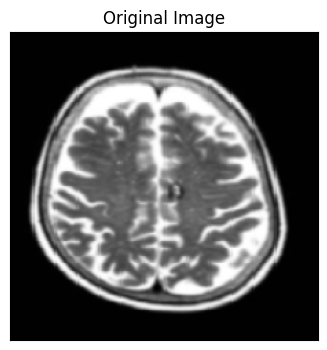

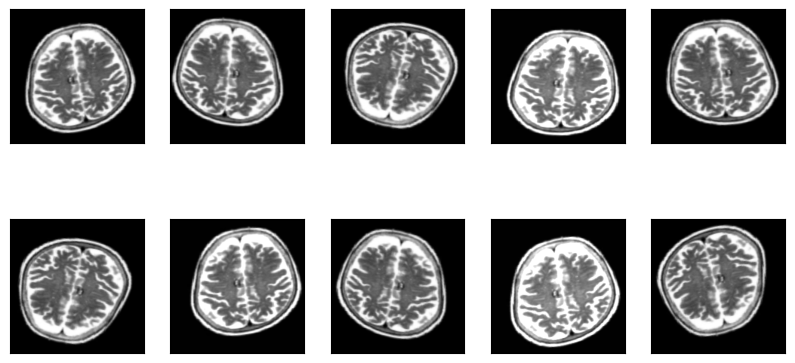

In [19]:

#demo of imagegenerator

demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# Load an image
image = X_train_crop[random.randint(1,len(X_train_crop))]

# the rank of the image must be 4
image = image.reshape((1,224,224,1))

# Generate augmented images
augmented_images = demo_datagen.flow(
    x=image,
    batch_size=1,
    shuffle=False
)

num_augmented_images = 10

# Plot the original image
plt.figure(figsize=(8, 4))
plt.imshow(image[0, :, :, 0], cmap='gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

# Plot the augmented images
plt.figure(figsize=(10,5))
for i, augmented_image in enumerate(augmented_images):
    columns = 5
    plt.subplot(int(num_augmented_images/columns),columns,i+1)
    plt.imshow(augmented_image[0, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    if i >= num_augmented_images - 1:
        break
